# Exploratory Data Analysis with Pandas

The main scope of this notebook is to perform an analysis of the reviews received for the applications (games) in Steam. Each row in the dataset represents a review made by one user (Author) about a specific application.
The goal will be to answer different possible research questions.

### Useful imports to analyze the dataset and analyze the results

In [ ]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr, mannwhitneyu, shapiro, ttest_ind, normaltest
import seaborn as sea
from mpl_toolkits import mplot3d
import statsmodels.api as sm
import plotly.express as px
from sklearn import preprocessing 

## Preparing the data
First we have to load the .csv files and merge them in a single dataframe. We will only select the columns of interest and skip rows that give troubles (for example different types in the same column due to the merge).

In [ ]:
columns = ["app_id", "review_id","app_name",  "language", "timestamp_created", "timestamp_updated", "recommended",                               
"votes_helpful", "votes_funny", "weighted_vote_score", "received_for_free", "steam_purchase", "author.steamid", 
"author.num_reviews", "author.playtime_at_review"]

To parse the dates we'll use this simple function that converts a timestamp in seconds into a date

In [ ]:
def dateparse(time_in_secs):
    return pd.to_datetime(time_in_secs, unit='s')

In [ ]:
df1 = pd.read_csv("./steam_reviews.csv", usecols = columns, 
               parse_dates=['timestamp_created', 'timestamp_updated'],
               date_parser= dateparse)

df2 = pd.read_csv("./steam_reviews_1.csv", usecols = columns, 
               parse_dates=['timestamp_created', "timestamp_updated"], skiprows=[234060, 5938492, 8278792, 9163394],
               date_parser=dateparse)

df3 = pd.read_csv("./steam_reviews_2.csv",  usecols = columns, 
               parse_dates=['timestamp_created', 'timestamp_updated'], skiprows=[3895921, 3984228, 5893390, 1929921],
               date_parser=dateparse)

To build the actual dataframe we concatenate the dataframes along the rows with the pandas method concat that is almost the same as numpy's concatenate

In [ ]:
df = pd.concat([df1, df2, df3], ignore_index=True)

Given that the dataframes will consume much memory we suggest to delete the unused ones when possible

In [ ]:
# deleting unused data frames
del [[df1,df2, df3]]

## Let's take a first look at the dataframe

We can see how many records are stored by using the method _shape_

In [ ]:
df.shape

(38747371, 15)

Print the first **k** records with the method _head_

In [ ]:
# print a few lines of the dataset to visualize the format 
df.head(5)

,app_id,app_name,review_id,language,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,steam_purchase,received_for_free,author.steamid,author.num_reviews,author.playtime_at_review
0,292030,The Witcher 3: Wild Hunt,85185598,schinese,2021-01-23 06:00:29,2021-01-23 06:00:29,True,0.0,0.0,0.0,True,False,7.656120e+16,2.0,1909.0
1,292030,The Witcher 3: Wild Hunt,85185250,schinese,2021-01-23 05:50:30,2021-01-23 05:50:30,True,0.0,0.0,0.0,True,False,7.656120e+16,10.0,2674.0
2,292030,The Witcher 3: Wild Hunt,85185111,schinese,2021-01-23 05:46:40,2021-01-23 05:46:40,True,0.0,0.0,0.0,True,False,7.656120e+16,1.0,1060.0
3,292030,The Witcher 3: Wild Hunt,85184605,english,2021-01-23 05:32:50,2021-01-23 05:32:50,True,0.0,0.0,0.0,True,False,7.656120e+16,3.0,5524.0
4,292030,The Witcher 3: Wild Hunt,85184287,schinese,2021-01-23 05:23:47,2021-01-23 05:23:47,True,0.0,0.0,0.0,True,False,7.656120e+16,4.0,217.0


Or even check the type of each column with _info_

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38747371 entries, 0 to 38747370
Data columns (total 15 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   app_id                     int64         
 1   app_name                   object        
 2   review_id                  int64         
 3   language                   object        
 4   timestamp_created          datetime64[ns]
 5   timestamp_updated          datetime64[ns]
 6   recommended                object        
 7   votes_helpful              float64       
 8   votes_funny                float64       
 9   weighted_vote_score        float64       
 10  steam_purchase             object        
 11  received_for_free          object        
 12  author.steamid             float64       
 13  author.num_reviews         float64       
 14  author.playtime_at_review  float64       
dtypes: datetime64[ns](2), float64(6), int64(2), object(5)
memory usage: 4.3+ GB


The _describe_ method will give us some statistics about the quantitative features of the dataframe

In [ ]:
# print different statitics of each columns of the datasets
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe()[1:]

,app_id,review_id,votes_helpful,votes_funny,weighted_vote_score,author.steamid,author.num_reviews,author.playtime_at_review
mean,397489.121,52065939.399,454024.616,120378.912,0.162,76561198148967024.000,454033.090,8974.073
std,254685.673,20914457.694,1413086414.379,22737756.822,0.242,308285377.089,1413086414.377,24213.165
min,70.000,43.000,0.000,0.000,0.000,76561197860265728.000,1.000,1.000
25%,250900.000,36583569.000,0.000,0.000,0.000,76561197917248576.000,2.000,554.000
50%,359550.000,54270641.000,0.000,0.000,0.000,76561198021813296.000,4.000,1870.000
75%,578080.000,69557564.000,1.000,0.000,0.480,76561198219021776.000,9.000,6941.000
max,1291340.000,85218673.000,4398046511106.000,4294967295.000,0.996,76561199133265376.000,4398046511108.000,3228103.000


##  Let's explore the dataset by finding simple insights into the reviews.
Some of the tasks we would like to complete are:
- Plot the number of reviews for each application in descending order.
- Find the applications with the best Weighted Vote Score?
- Find the applications with the most and the least recommendations?
- How many of these applications were purchased, and how many were given for free?

### Building a sub-dataframe for the games

In order to answer this questions is useful to create a dataframe containing the information we need for each game:
   - n_reviews: the total number of reviews for that application
   - weighted_score_mean: the average the weighted score for the application
   - recommended: the number of people who recommended this application

In [ ]:
# first we count the number of reviews for each game by grouping and counting the number of different (unique) reviews_id
n_reviews = df.groupby("app_name")["review_id"].count()

# Then we take the average Weighted vote score grouping by the app name
weighted_score_mean = df.groupby("app_name")["weighted_vote_score"].mean()

# Now we count the number of recommendations
recommendations = df.groupby("app_name")["recommended"].sum()

We separately store in a variable the number of copies for each game that were acquired for free or purchased

In [ ]:
gratis = df.groupby("received_for_free").review_id.count()

In [ ]:
# Create a new dataframe concatenating the columns
game_df = pd.concat([n_reviews, weighted_score_mean, recommendations], axis=1).reset_index()

# Rename columns in  a clearer way
game_df.rename(columns={"review_id": "n_reviews", "weighted_vote_score": "weighted_score_mean"}, inplace=True)

Let's take a look at this new dataframe

In [ ]:
game_df.head()

Now we would like to order each column separately in order to find the best and worst games for each of them, this will also help us to plot them later. We take the first 20 games.

In [ ]:
# most reviewed
most_reviewed = game_df.sort_values(by="n_reviews", ascending=False)[:20]

# highest score
highest_score =  game_df.sort_values(by="weighted_score_mean", ascending=False)[:20]

# most and least recommended
most_recommended = df_per_game.sort_values(by="recommended", ascending=False)[:20]
least_recommended = df_per_game.sort_values(by="recommended", ascending=True)[:20]

Who is the most recommended? and the least?

In [12]:
print(most_recommended["app_name"].iloc[0], 'has the most recommendations:', most_recommended["recommended"].iloc[0])
print(least_recommended["app_name"].iloc[0], 'has the least recommendations:', least_recommended["recommended"].iloc[0])

PLAYERUNKNOWN'S BATTLEGROUNDS has the most recommendations: 1772834
Neon Hardcorps has the least recommendations: 178


### Plotting the results
For this task we will use _cmap_ to have colorful barplots and we will implement a function to return a plot given the correct data.

In [ ]:
# to use cmaps
rescale = lambda y: (y*3 - np.min(y)) / (np.max(y) - np.min(y)) 

#funtion to use cmap with plt.bar
def c_map(cmap_name,y):
    return plt.get_cmap(cmap_name)(rescale(y))

#cmap color extractor
def colors_from_cmap(cmap_name, length): 
    colors = plt.get_cmap(cmap_name)(np.linspace(0.2, 1, length))
    return colors

The actual function to plot the data

In [ ]:
def cmap_barplot(x, y, size, title, xlab = '', ylab = '', color_map, num_colors)
    '''
    function to plot a barplot with cmap
    inputs:
    x, y = a column of a dataframe
    size = a tuple with the figure size
    title = the figure titleù
    xlab, ylab = axis labels
    color_map = a string specifying the color map to apply
    num_colors = number of colors required
    '''
    fig = plt.figure(0, figsize=(15, 7));
    plt.title(title);
    plt.barh(y.iloc[::-1],
             x.iloc[::-1],
             color=colors_from_cmap(color_map, num_colors));
    plt.xlabel(xlab);
    plt.ylabel(ylab);
    plt.show();

#### Plot for the most reviewed games

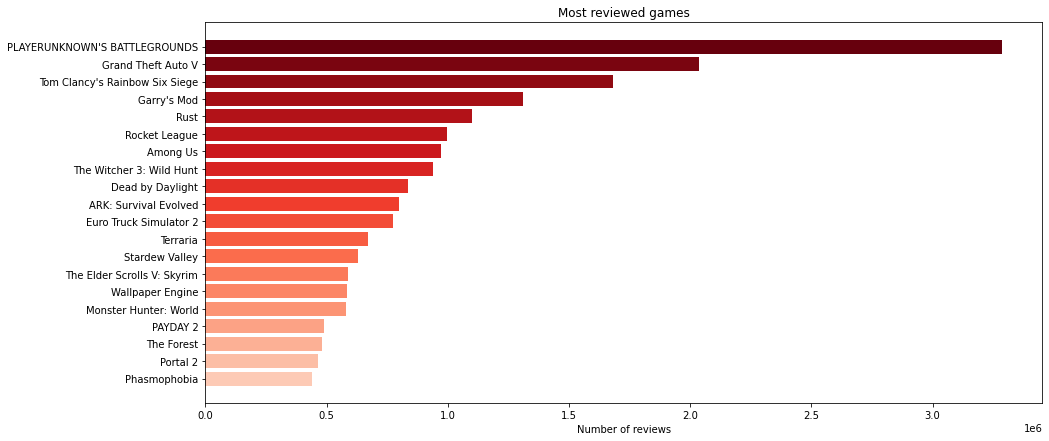

In [16]:
cmap_barplot(most_reviewed["app_name"].iloc[::-1], most_reviewed["n_reviews"].iloc[::-1], 
             (15, 7), "Most reviewed games", "Number of reviews", 'Games', "Reds", 20)

#### Plot for the most recommended games

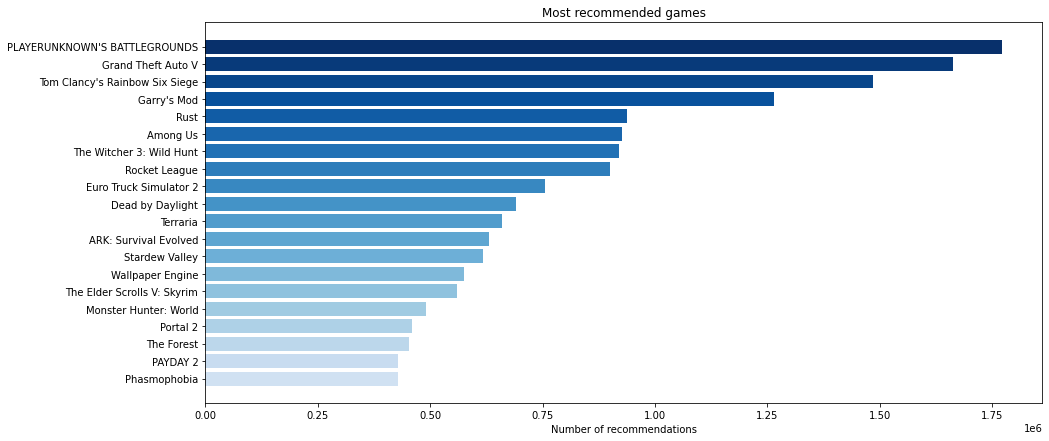

In [17]:
cmap_barplot(most_reviewed["app_name"].iloc[::-1], most_reviewed["recommended"].iloc[::-1], 
             (15, 7), "Most recommended games", "Number of recommendations", 'Games', 'Blues', 20)

#### Plot for the least recommended games

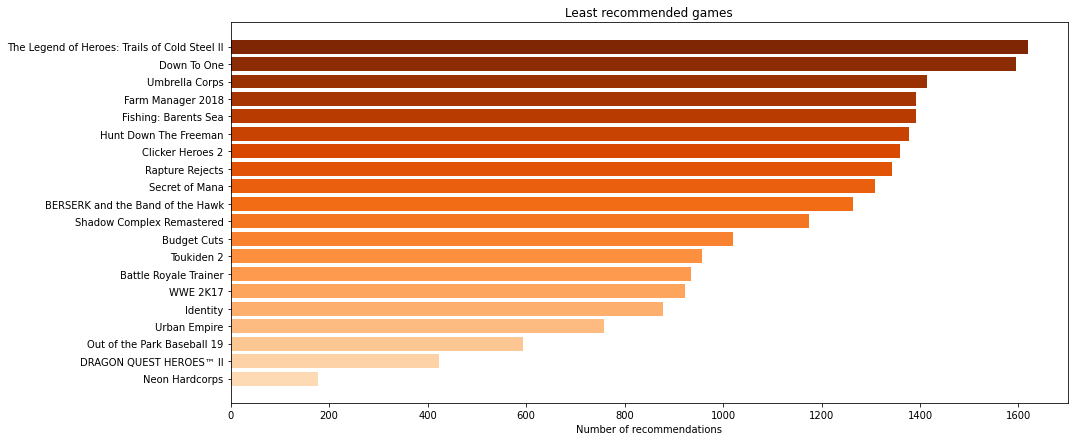

In [ ]:
cmap_barplot(most_reviewed["app_name"], most_reviewed["recommended"], 
             (15, 7), "Least recommended games", "Number of recommendations", 'Games', 'Oranges', 20)

#### Highest scored games

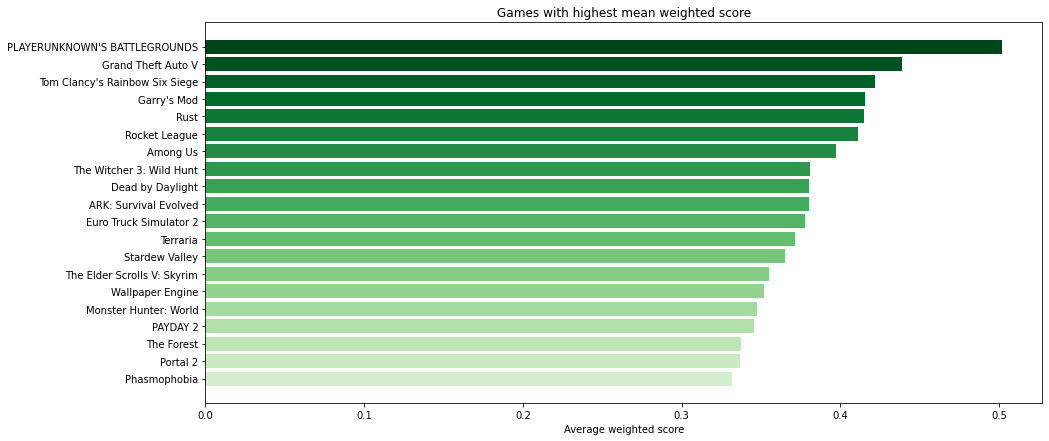

In [ ]:
cmap_barplot(most_reviewed["app_name"].iloc[::-1], most_reviewed["weighted_score_mean"].iloc[::-1], 
             (15, 7), "Highest scored games", "Average weighted score", 'Games', 'Greens', 20)

#### Pie plot of the purchased and for free games

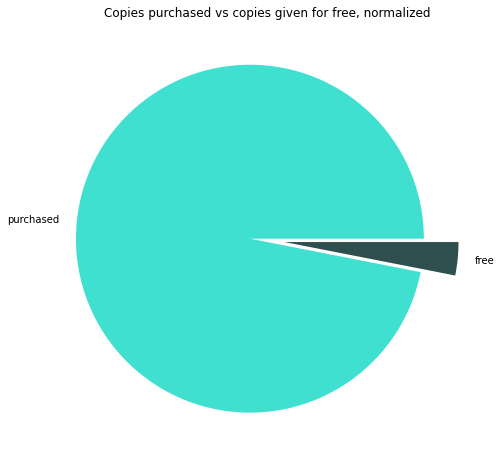

In [43]:
fig = plt.figure(0, figsize=(8, 8))
plt.title("Applications purchased vs applications given for free");
plt.pie(labels = ["purchased", "free"],
       x = gratis/df.shape[0],
       colors=["turquoise", "darkslategrey"], explode =  [0.1, 0.1]);
plt.title("Copies purchased vs copies given for free, normalized");

## What is the preferred time to review a game?
It might be useful to know the most common time to do a review and plot the number of reviews for given intervals of time.

For this task we will create a dataframe using only the columns that refer to the time a review has been made.

In [ ]:
# extract the column of timestamps
time_df = df[['timestamp_created']]

#Change the type and store in a new column
time_df['Time_review'] = pd.to_datetime(time_df['timestamp_created'], unit='s').dt.strftime('%H:%M')

Now we count the number of occurrencies for each unique time we have and find the most common. For instance this operation can be made also with different time formats (like only considering the hours without the minutes)

In [ ]:
# finds and print the max number of occurrencies and the time associated
ordered_time = time_df['Time_review'].value_counts().reset_index()
most_common_time = np.array(ordered_time.reset_index().head(1))[0]
print(most_common_time[0], 'is the most common time with', most_common_time[1], 'occurrencies')

14:50 is the most common time with 31247 occurrencies


In [ ]:
ordered_time

,index,Time_review
0,14:50,31247
1,15:05,31187
2,15:07,31187
3,14:46,31184
4,14:52,31163
...,...,...
1435,06:43,23562
1436,06:29,23561
1437,06:20,23544
1438,05:55,23454


### Plot the occurrences for an interval of time

In [42]:
def reviews_intervals(intervals): 
    '''
    Given a list of intervals this functions, a dataframe and a column of interest 
    creates an histogram of the frequencies for each interval
    '''
    
    initial, final = intervals[::2], intervals[1::2]
    intervals = pd.DataFrame({"Initial time": initial, "Final time": final})
    
    for i in range(len(intervals)):
        # create a new column for each interval and fill with 0 or 1 if the time review is the interval
        time_df[intervals.iloc[i,0]+'-'+intervals.iloc[i,1]]=np.where((intervals.iloc[i,0] <= time_df['Time_review']) & (time_df['Time_review'] <= intervals.iloc[i,1]) , 1, 0)
    
    #store the dataframe without the columns 'Time_review','timestamp_created'
    nb_review_intervals = time_df.drop(['Time_review','timestamp_created'], axis=1)
    
    nb_review_intervals.sum().plot.barh(title='Number of reviews for each interval', color=colors_from_cmap('autumn', intervals.shape[0]), figsize=(10,7));

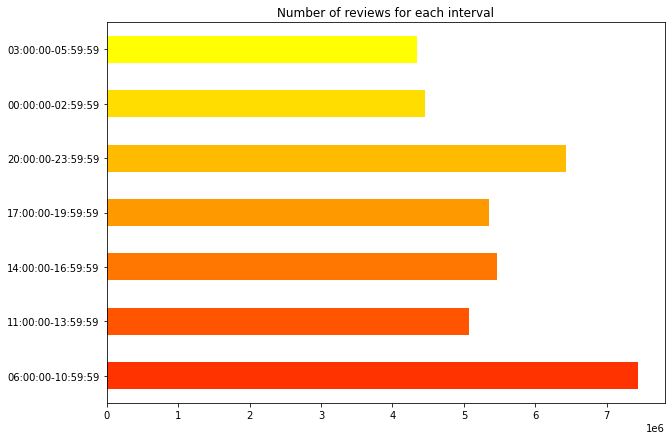

In [43]:
# create the nested list of the homework example
intervals = ['06:00:00',  '10:59:59', '11:00:00', '13:59:59','14:00:00', '16:59:59', '17:00:00', '19:59:59', '20:00:00', '23:59:59','00:00:00','02:59:59', '03:00:00', '05:59:59'] 

#apply the function 'reviews_intervals'
reviews_intervals(intervals)

## What are the most common languages?
The reviews are done from all over the world but what are the most common ones?

We can answer this by grouping and counting, then we'll extract some informations from a filtered dataset with only the most relevant languages.

In [33]:
# sorted number of reviews in each language in descending order
reviews_per_language = df.groupby("language")["review_id"].count().sort_values(ascending=False)

#store and print top three languages
top_three_languages = reviews_per_language[:3].index.tolist()
print('The Top 3 languages are :',*top_three_languages)

The Top 3 languages are : english schinese russian


Here we create the function we will use to filter the dataset by language.

In [32]:
def filter_by_language(df, languages):
    #data frame filtered only with the reviews written in the provided languages
    filtered_df = df[df["language"].isin(languages)]
    return filtered_df

Next we use our function filter_by_language to retrieve the subset of the dataframe pertaining to the three top languages.

We are interested for these languages to see which games have been voted as funny or helpful by creating two new boolean variables. Indeed, here we consider that a review is funny or helpful if it has one vote or more but this threshold can be changed with the variable threshold

In [34]:
filtered_df = filter_by_language(df, top_three_languages)

In [35]:
n = len(filtered_df)

#i fix a threshold which represent the minimum number of vote to consider the review helpful or funny
threshold=1

# new dataframe in which we create two new boolean attributes to know if we have more votes than the threshold 
filtered_df = filtered_df.assign(was_funny=lambda x: x["votes_funny"] >= threshold,
                                                       was_helpful=lambda x: x["votes_helpful"] >= threshold)
# compute the percentage of funny and helpful rewiews
funny_or_not = filtered_df.groupby("was_funny")["review_id"].count() / n
helpful_or_not = filtered_df.groupby("was_helpful")["review_id"].count() / n

And now we plot the results.

#### Barplot for the reviews per language

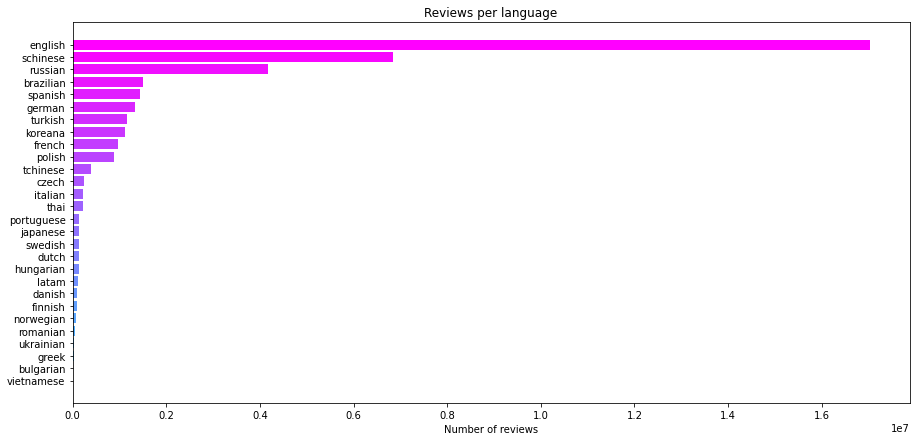

In [ ]:
cmap_barplot(reviews_per_language.index[::-1], reviews_per_language[::-1], 
             (15, 7), "Reviews per language", "# of reviews",
             'languages', "cool", len(reviews_per_language.index))

#### Pie plot for funny or not reviews

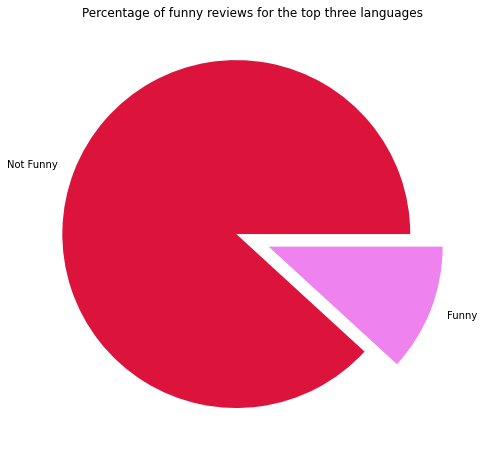

In [39]:
fig_2 = plt.figure(figsize=(8, 8))
plt.pie(labels = ['Not Funny', 'Funny'],
        x = funny_or_not,
        colors=["crimson","violet"], explode = [0.1,0.1])
plt.title("Percentage of funny reviews for the top three languages")
plt.show()

#### Pie plot for helpful or not reviews

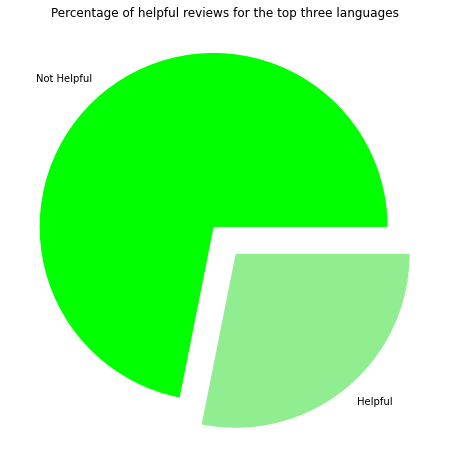

In [42]:
fig_2 = plt.figure(figsize=(8,8))
plt.pie(labels = ['Not Helpful','Helpful'],
        x = helpful_or_not,
        colors =["lime", "lightgreen"], explode = [0.1, 0.1])
plt.title("Percentage of helpful reviews for the top three languages")
plt.show()

## Insights about the authors of the reviews
The reviews' authors are users from the game that provide their opinion on it. Nowwe can check how often they make reviews.

First of all, we retrieve the number of reviews submitted by each author. And then order them in descending order and retrieve the top 10 authors (in terms of number of contributions) and we plot the results (after transforming each id in a string).

In [45]:
#compute the number of review per reviewer "author.steamid"
author_df = df.groupby("author.steamid")["review_id"].count()

In [46]:
# store the top 10
top_10_reviewers = author_df.sort_values(ascending=False).iloc[:10]

#change the type to obtain labels (str)
authors_names = list(map(str, top_10_reviewers.index.tolist()))

#### Barplot of the reviewers

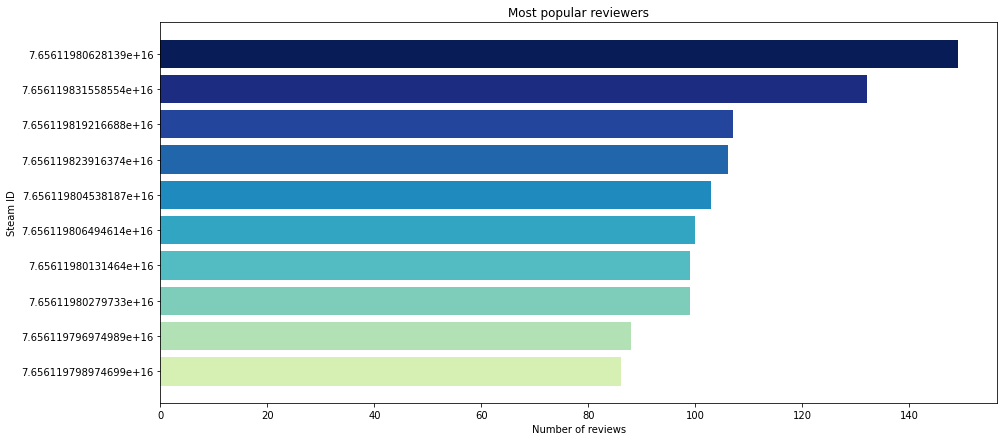

In [47]:
cmap_barplot(authors_names[::-1], top_10_reviewers[::-1], 
             (15, 7),"Most popular reviewers","Number of reviews",
             "Steam ID", "YlGnBu", len(authors_names))

Let' find the top reviewer and analyze him mire in depth by obtaining the name of all the applications he reviewed.


In [48]:
top_reviewer = authors_names[0]
print('The most popular reviewer has the id',top_reviewer)

The most popular reviewer has the id 7.65611980628139e+16


In [49]:
top_reviewer = df[df["author.steamid"]==float(top_reviewer)]

In [50]:
print('The top reviewer wrote reviews about :\n')
for app in pd.unique(top_reviewer["app_name"]):
    print('\t'+app) 

The top reviewer wrote reviews about :

	Half-Life
	Counter-Strike: Source
	Half-Life 2: Episode Two
	Portal 2
	Garry's Mod
	Sid Meier's Civilization V
	Dead by Daylight
	Sid Meier's Civilization VI
	Subnautica
	Human: Fall Flat
	Banished
	Celeste
	Getting Over It with Bennett Foddy
	A Hat in Time
	The Forest
	Axiom Verge
	The Binding of Isaac: Rebirth
	To the Moon
	Cave Story+
	Titan Souls
	Super Meat Boy
	Don't Escape: 4 Days to Survive
	Volgarr the Viking
	Enter the Gungeon
	Salt and Sanctuary
	Hollow Knight
	The End Is Nigh
	Factorio
	RimWorld
	Insurgency: Sandstorm
	Euro Truck Simulator 2
	Foundation
	Kenshi
	Into the Breach
	Warhammer: Vermintide 2
	DOOM Eternal
	Age of Empires: Definitive Edition
	Void Bastards
	Stardew Valley
	Among Us
	Blackwake
	Little Nightmares
	Bomber Crew
	Rust
	HITMAN™ 2
	Phasmophobia
	Mount & Blade: Warband
	Resident Evil 2
	Slime Rancher
	Hotline Miami
	Tomb Raider
	BattleBlock Theater
	Dishonored
	South Park™: The Stick of Truth™
	Undertale
	Don't Sta

And now we specifically save the information about the number of copies he purchased or received for free and whether he recommended them or not.

N.B. : We consider that a person wrote a review only if he played this game, so if he did nit obtain it for free he bought it.

In [51]:
free_or_not_top_reviewer = top_reviewer.groupby("received_for_free")["review_id"].count()
free_or_not_top_reviewer / len(top_reviewer)

received_for_free
False    0.973154
True     0.026846
Name: review_id, dtype: float64

As we can see the number of games received for free is not large enough to allow us to infer some informations for this reason we'll focus onthe purchased games.

In [52]:
recommended_purchased = top_reviewer[top_reviewer["received_for_free"]==False].groupby("recommended")["review_id"].count()
recommended_purchased

recommended
False      3
True     142
Name: review_id, dtype: int64

And now we plot the results.

#### Pie plot of the recommended games purchased from the top reviewer

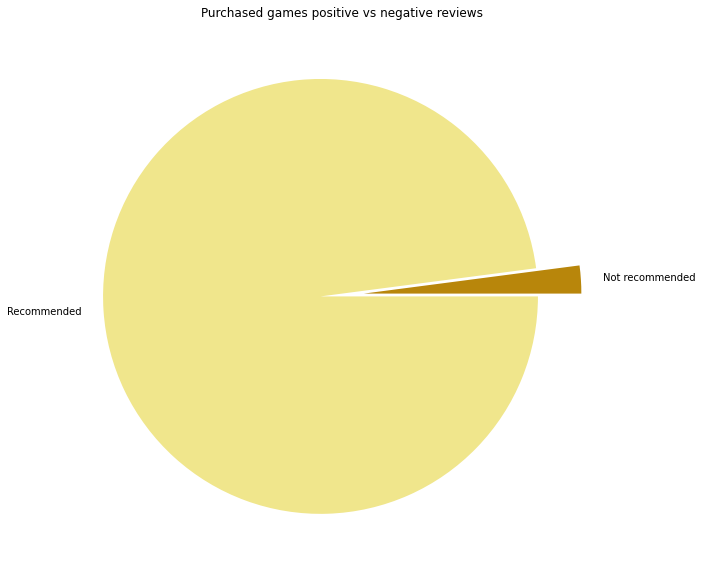

In [49]:
plt.figure(figsize=(10,10))
plt.pie(labels=["Not recommended", "Recommended"],
        x = recommended_purchased,
        colors=["darkgoldenrod","khaki" ], explode = [0.1, 0.1])
plt.title("Purchased games positive vs negative reviews");